****SAR imagery classification****

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/resnet34/resnet34.pth
/kaggle/input/sar-iceberg/sample_submission.csv
/kaggle/input/sar-iceberg/train.json
/kaggle/input/sar-iceberg/test.json


In [3]:
#delete pictures in folder
# shutil.rmtree('./data/composites/')


In [4]:
train = pd.read_json('../input/sar-iceberg/train.json')
test = pd.read_json('../input/sar-iceberg/test.json')
train.head()

id                                             band_1  \
0  dfd5f913  [-27.878360999999998, -27.15416, -28.668615, -...   
1  e25388fd  [-12.242375, -14.920304999999999, -14.920363, ...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.259186, -30.259186, -23.16495...   35.6256           0

We can see we have to convert the data to an image then use a model to classify it , resnet34 with 2 blank matrices at the end.

**Distribution of target variable:**

Text(0.5, 1.0, 'Target variable distribution')

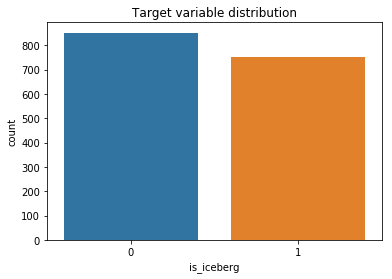

In [5]:
sns.countplot(train.is_iceberg).set_title('Target variable distribution')

Data is balanced

In [6]:
# get more info on dataset
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
id            1604 non-null object
band_1        1604 non-null object
band_2        1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 4 columns):
id           8424 non-null object
band_1       8424 non-null object
band_2       8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 263.4+ KB


(None, None)

In [7]:
#will check to repositioning picture according to angle of satellite.
train.inc_angle = train.inc_angle.replace('na', 0, inplace=True)
train.inc_angle.describe()

count       0
unique      0
top       NaN
freq      NaN
Name: inc_angle, dtype: object

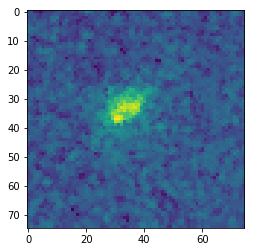

In [8]:
#let's see an image
img1 = train.loc[5, ['band_1', 'band_2']]
img1 = np.stack([img1['band_1'], img1['band_2']], -1).reshape(75, 75, 2)
plt.imshow(img1[:, :, 0] )

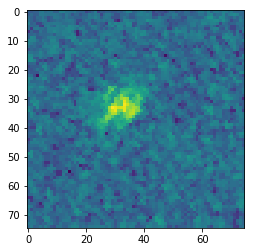

In [9]:
plt.imshow(img1[:, :, 1] )

**Image creation (to Jpgs)**

In [10]:
#shape of dataset
train.shape

(1604, 5)

In [11]:
#this will help us to have more images and allowing us to see more charactersitics in image
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75) 
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [12]:
rgb_train = color_composite(train)
rgb_test = color_composite(test)

In [13]:
print('The train shape {}'.format(rgb_train.shape))
print('The test shape {}'.format(rgb_test.shape))

The train shape (1604, 75, 75, 3)
The test shape (8424, 75, 75, 3)


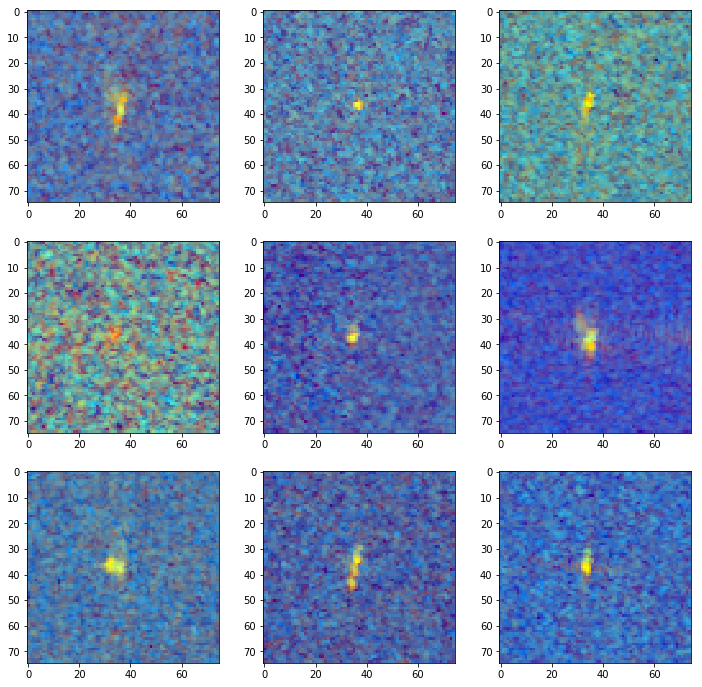

In [14]:
#look at some ships
ships = np.random.choice(np.where(train.is_iceberg ==0)[0], 9)
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ships[i], :, :]
    ax.imshow(arr)
    
plt.show()

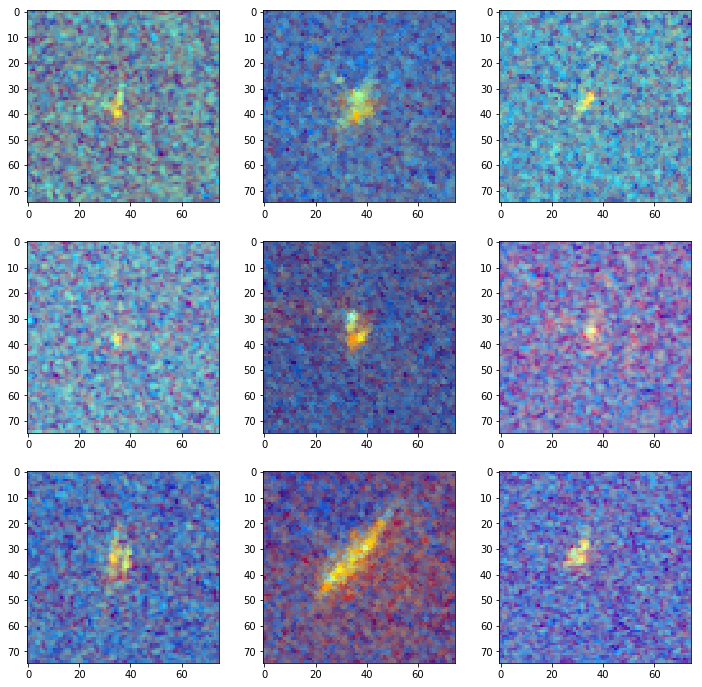

In [15]:
#look at some iceberg
iceberg = np.random.choice(np.where(train.is_iceberg ==1)[0], 9)
fig = plt.figure(1,figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[iceberg[i], :, :]
    ax.imshow(arr)
    
plt.show()

In [16]:
#for creating labels and folders
#we have to label if iceberg or ship therefore I will create 2 folders - one ship, one iceberg in train set.
iceberg = train[train.is_iceberg==1]
ship = train[train.is_iceberg==0]

In [17]:
#save images to disk
os.makedirs('./data/composites', exist_ok= True)
os.makedirs('./data/composites/train/ship', exist_ok=True)
os.makedirs('./data/composites/train/iceberg', exist_ok=True)
os.makedirs('./data/composites/test', exist_ok=True)

#save train iceberg images
for idx in iceberg.index:
    img = rgb_train[idx]    
    plt.imsave('./data/composites/train/iceberg_' + str(idx) + '.png',  img)
        
#save train ship images
for idx in ship.index:
    img = rgb_train[idx]    
    plt.imsave('./data/composites/train/ship_' + str(idx) + '.png',  img)

       
#save test images
for idx in range(len(test)):
    img = rgb_test[idx]
    plt.imsave('./data/composites/test/' + str(idx) + '.png',  img)

In [18]:
# GPU required
torch.cuda.is_available()

True

In [19]:
torch.backends.cudnn.enabled

True

In [20]:
#copy model to kernel resnet 34
# Fix to enable Resnet to live on Kaggle - creates a writable location for the models
cache_dir = os.path.expanduser(os.path.join('~', '.torch'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
   # print("directory created :" .cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
  #  print("directory created :" . cache_dir)

In [21]:
!cp ../input/resnet34/resnet34.pth ~/.torch/models/resnet34-333f7ec4.pth 

In [22]:
#get pictures/files directory
path = '../working/data/composites/'
path_img = '../working/data/composites/train/'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../working/data/composites/train/iceberg_1085.png'),
 PosixPath('../working/data/composites/train/ship_1110.png'),
 PosixPath('../working/data/composites/train/ship_1338.png'),
 PosixPath('../working/data/composites/train/iceberg_1014.png'),
 PosixPath('../working/data/composites/train/iceberg_1029.png')]

In [23]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.png$'
                     
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.3, max_warp=0.2)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, valid_pct=0.3 ,  ds_tfms=tfms , size=128, bs= 256 , resize_method=ResizeMethod.CROP, 
                     padding_mode='reflection').normalize(imagenet_stats)
data.classes

['iceberg', 'ship']

**added imagenet weights**

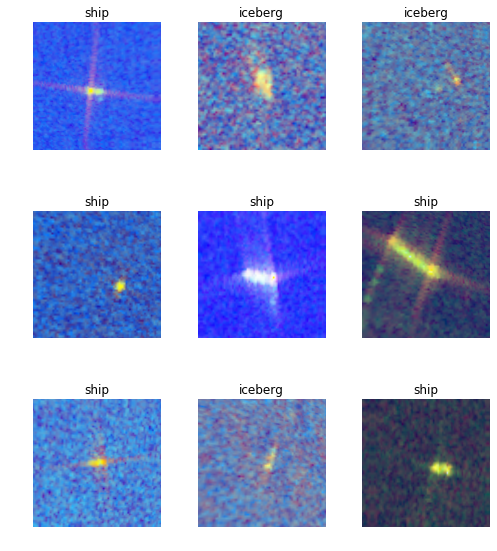

In [24]:
#let's check image + label
data.show_batch(rows=3,figsize=(7,8))

In [25]:
#create a learner
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy] ,model_dir= '/tmp/models/')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [26]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
___________________________________________________

In [27]:
learn.fit_one_cycle(4)

In [28]:
learn.save('stage-1')

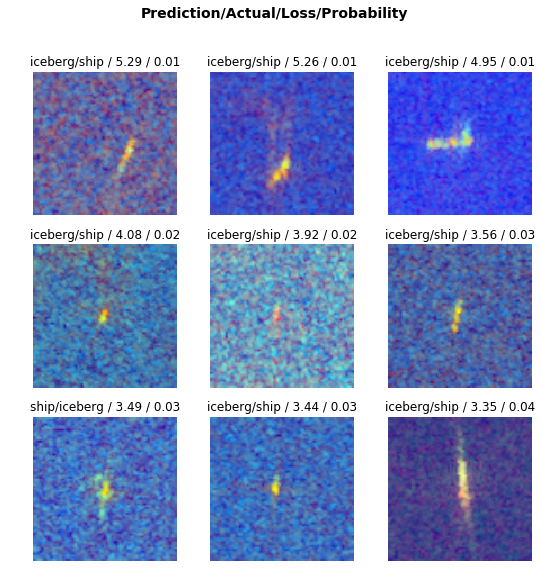

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize =(9,9))

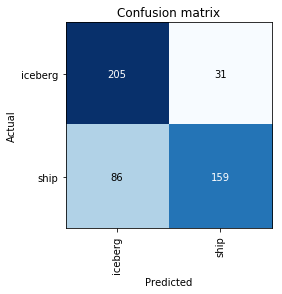

In [30]:
interp.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 8.32E-03


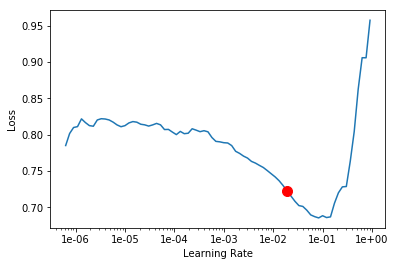

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
lr = 8e-03
learn.fit_one_cycle(5, lr)

In [33]:
learn.save('stage-2')

The learner has a built in method for plotting the training and validation loss.

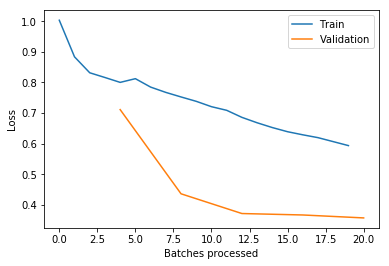

In [34]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 8.32E-03


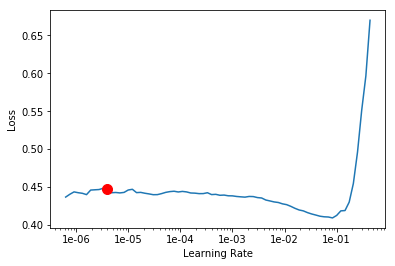

In [35]:
#Initiating refit and checking LR
learn.unfreeze
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [36]:
# access the corresponding learning rate 
# min_grad_lr = learn.recorder.min_grad_lr
# min_grad_lr

In [37]:
learn.fit_one_cycle(10, slice(1e-03, 1e-02))

In [38]:
learn.save('stage-3')

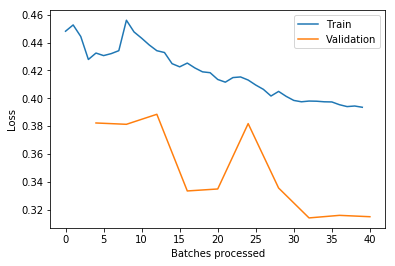

In [39]:
learn.recorder.plot_losses()

In [40]:
#create a new learner
# learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy] ,callback_fns=[partial(SaveModelCallback)],
#                     wd=0.1,ps=[0.9, 0.6, 0.4])
# learn = learn.load('stage-3')

it becomes to be alike...

In [41]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 0.3148878216743469


Explring the result

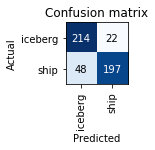

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2,2))

In [43]:
test = pd.read_json('../input/sar-iceberg/test.json')
Xtest = get_images(test)
test_predictions = model.predict_proba(Xtest)
submission = pd.DataFrame({'id': test['id'], 'is_iceberg': test_predictions[:, 1]})
submission.to_csv('sub_fcn.csv', index=False)

NameError: name 'get_images' is not defined